In [ ]:
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator  #keras로부터 ImageDataGenerator를 불러옵니다
import numpy as np
import pandas as pd 
from keras.utils import to_categorical    #데이터를 다루는데 필요한 라이브러리를 불러옵니다.
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
# 폴더에 파일이 있는지 확인
print(os.listdir('/content/drive/MyDrive/deep_learning/팀플/data/'))   #os.listdir() 메서드는 경로 내에 있는 파일의 이름을 리스트의 형태로 반환합니다.

['sampleSubmission.csv', 'test1.zip', 'train.zip', 'test2.zip', 'test3.zip']


In [ ]:
# zip 파일 열기
import zipfile

original_base_dir = '/content/datasets'
os.mkdir(original_base_dir)
dataset_zip = zipfile.ZipFile('/content/drive/MyDrive/deep_learning/팀플/data/test2.zip')   #zipfile 라이브러리의 ZipFile 클래스로 ZIP 파일을 연 후에
dataset_zip.extractall(original_base_dir)                                                   #extractall() 메서드를 이용하여 kaggle/working/dataset 폴더에 압축을 풉니다.
dataset_zip.close()

In [ ]:
# 데이터 프레임화 진행
test_filenames = os.listdir("/content/datasets/")    #os.listdir() 메서드는 경로 내에 있는 파일의 이름을 리스트의 형태로 반환합니다.
test_df=pd.DataFrame({
    'filename': test_filenames
})

nb_samples = test_df.shape[0]

In [ ]:
# 데이터 형상 관련 상수 정의
IMAGE_WIDTH=150                           #가로 150으로 설정
IMAGE_HEIGHT=150                          #세로 150으로 설정
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)    #150x150의 크기
IMAGE_CHANNELS=3
batch_size=15

In [ ]:
# 전처리 과정, 크기 조정
test_gen=ImageDataGenerator(rescale=1./255)       #이미지를 1/255로 스케일을 조정 
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/datasets/",
    x_col='filename',                             # filename를 열이름
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,                       #이미지 사이즈
    batch_size=batch_size,                        #배치사이즈
    shuffle=False 
)

Found 100 validated image filenames.


In [ ]:
# 모델 만들기
from keras.backend import dropout
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras import layers, models

#tf.keras.models 모듈의 Sequential 클래스를 사용해서 인공신경망의 각 층을 순서대로 쌓아줌
#add() 메서드를 이용해서 합성곱 층 Conv2D와 Max pooling 층 MaxPooling2D를 반복해서 구성
#첫번째 Conv2D 층의 첫번째 인자 32는 filters 값  #두번째 인자 (3, 3)은 kernel_size 값  ,활성화 함수는 relu 지정
#풀링의 크기는 2X2로 설정
#드롭아웃은 0.25 로 설정

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25)) 

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 72, 72, 64)      

In [ ]:
# 모델 컴파일 지정
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),        #학습률 같은 경우 일반적으로 0.01을 사용함
              loss='categorical_crossentropy',               #손실함수로는 categorical_crossentropy 사용함
              metrics=['accuracy'])

In [ ]:
# A2에서 만들었던 모델 가져오기
a2 = model.load_weights('A2model.h5')
# 예측진행
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-15-7b1b90aedba6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category']=np.argmax(predict, axis=-1)

In [ ]:
# 컬럼 카테고리를 스트링으로 변경함.
#cat는 0 , dog는 1을 반환함
test_df['category']=test_df['category'].replace({'dog':1, 'cat':0})

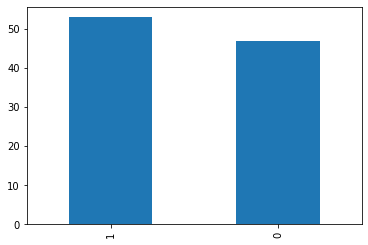

In [ ]:
test_df['category'].value_counts().plot.bar()

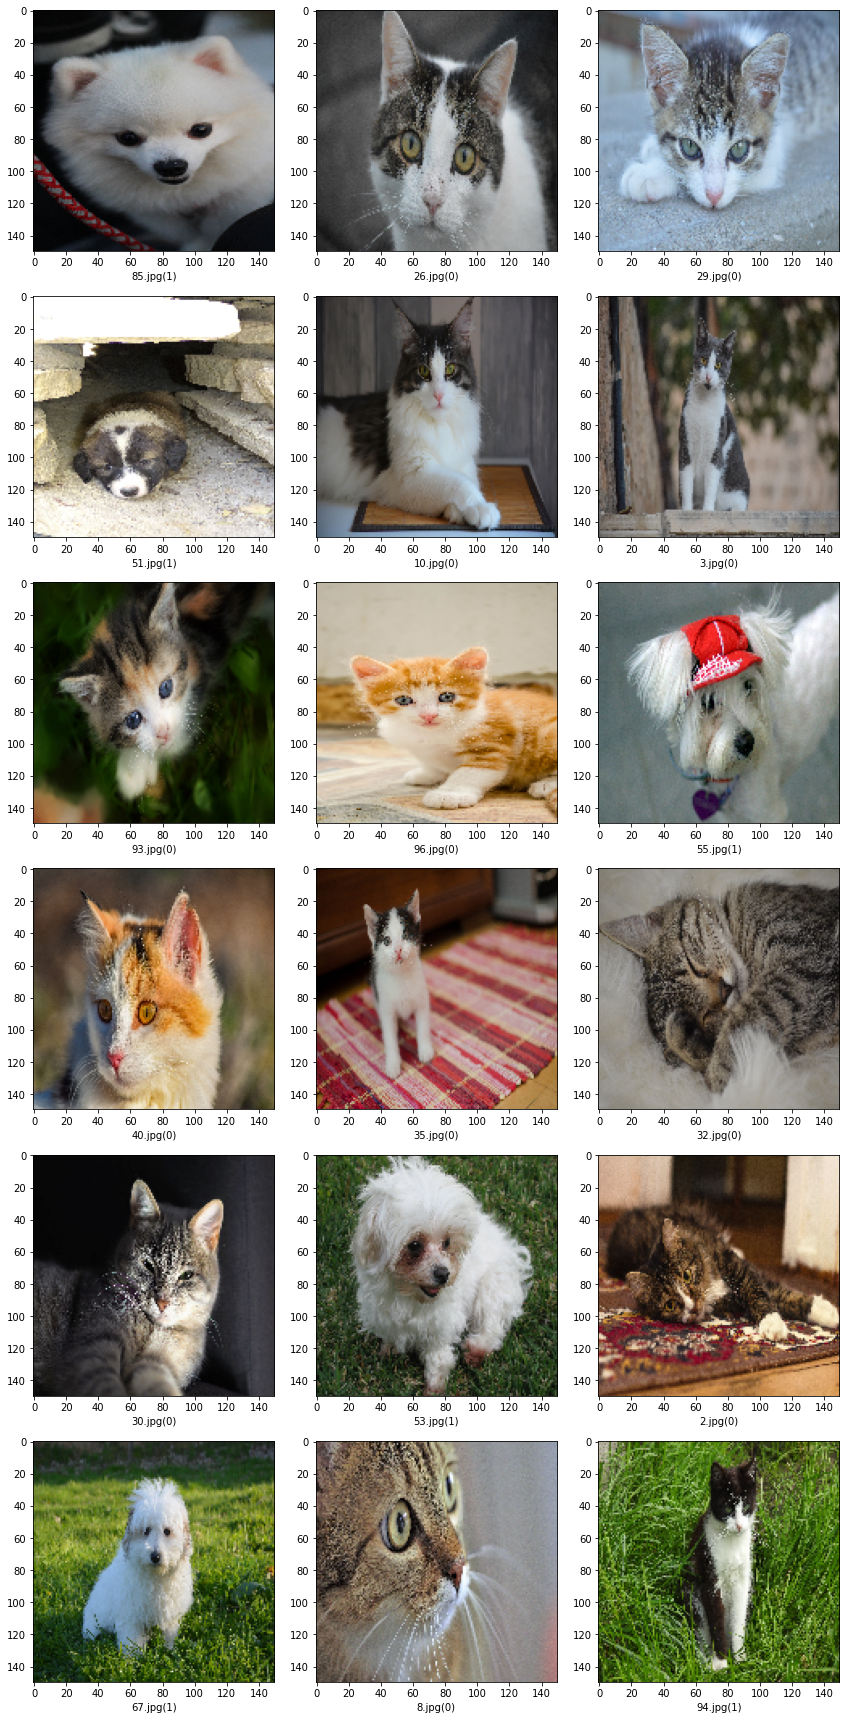

In [ ]:
# 이미지 확인
import keras.utils as image

sample_test=test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
  filename=row['filename']
  category=row['category']
  img=image.load_img("/content/datasets/"+filename, target_size=IMAGE_SIZE)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename+'('+"{}".format(category)+')')
plt.tight_layout()
plt.show()

In [ ]:
# submission에 저장
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]     # submission의 id 부분 생성
submission_df['label'] = submission_df['category']                        # submission의 label 부분 생성
submission_df.drop(['filename', 'category'], axis=1, inplace=True)        # 기존 열 삭제

In [ ]:
submission_df

,id,label
0,85,1
1,26,0
2,29,0
3,51,1
4,10,0
...,...,...
95,6,1
96,9,0
97,4,1
98,36,0


In [ ]:
submission_df.to_csv('submission_Competition_team6.csv', index=False)